In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import copy

# Dataset Preprocessing

In [31]:
base_path = r'C:\Users\RACYM\Desktop\fac\M2_PFE\datasets\CIC-DDoS2019\\'

cic_ddos2019 = {
    'DNS-test': pd.read_parquet(base_path + 'DNS-testing.parquet', engine='fastparquet'),

    'LDAP-test': pd.read_parquet(base_path + 'LDAP-testing.parquet', engine='fastparquet'),
    'LDAP-train': pd.read_parquet(base_path + 'LDAP-training.parquet', engine='fastparquet'),
    
    'MSSQL-test': pd.read_parquet(base_path + 'MSSQL-testing.parquet', engine='fastparquet'),
    'MSSQL-train': pd.read_parquet(base_path + 'MSSQL-training.parquet', engine='fastparquet'),
    
    'NetBIOS-test': pd.read_parquet(base_path + 'NetBIOS-testing.parquet', engine='fastparquet'),
    'NetBIOS-train': pd.read_parquet(base_path + 'NetBIOS-training.parquet', engine='fastparquet'),
    
    'NTP-test': pd.read_parquet(base_path + 'NTP-testing.parquet', engine='fastparquet'),
    
    'Portmap-train': pd.read_parquet(base_path + 'Portmap-training.parquet', engine='fastparquet'),
    'SNMP-test': pd.read_parquet(base_path + 'SNMP-testing.parquet', engine='fastparquet'),
    
    'Syn-test': pd.read_parquet(base_path + 'Syn-testing.parquet', engine='fastparquet'),
    'Syn-train': pd.read_parquet(base_path + 'Syn-training.parquet', engine='fastparquet'),
    
    'TFTP-test': pd.read_parquet(base_path + 'TFTP-testing.parquet', engine='fastparquet'),
    
    'UDPLag-test': pd.read_parquet(base_path + 'UDPLag-testing.parquet', engine='fastparquet'),
    'UDPLag-train': pd.read_parquet(base_path + 'UDPLag-training.parquet', engine='fastparquet'),
    
    'UDP-test': pd.read_parquet(base_path + 'UDP-testing.parquet', engine='fastparquet'),
    'UDP-train': pd.read_parquet(base_path + 'UDP-training.parquet', engine='fastparquet'),
}

# merging between train sets and test sets for each attack type
cic_ddos2019_merged = {
    'DNS': cic_ddos2019['DNS-test'],
    'LDAP': pd.concat([cic_ddos2019['LDAP-train'], cic_ddos2019['LDAP-test']], ignore_index=True),
    'MSSQL': pd.concat([cic_ddos2019['MSSQL-train'], cic_ddos2019['MSSQL-test']], ignore_index=True),
    'NetBIOS': pd.concat([cic_ddos2019['NetBIOS-train'], cic_ddos2019['NetBIOS-test']], ignore_index=True),    
    'NTP': cic_ddos2019['NTP-test'],
    'Portmap': cic_ddos2019['Portmap-train'],
    'SNMP': cic_ddos2019['SNMP-test'],
    'Syn': pd.concat([cic_ddos2019['Syn-train'], cic_ddos2019['Syn-test']], ignore_index=True),
    'TFTP': cic_ddos2019['TFTP-test'],
    'UDPLag': pd.concat([cic_ddos2019['UDPLag-train'], cic_ddos2019['UDPLag-test']], ignore_index=True),
    'UDP': pd.concat([cic_ddos2019['UDP-train'], cic_ddos2019['UDP-test']], ignore_index=True),
}

# merging all attack types 
cic_ddos2019_all = pd.concat(cic_ddos2019_merged.values(), ignore_index=True)

In [32]:
# raw_train = pd.read_parquet(r'C:\Users\RACYM\Desktop\fac\M2_PFE\datasets\CIC-DDoS2019\Syn-training.parquet', engine='fastparquet')
# raw_test = pd.read_parquet(r'C:\Users\RACYM\Desktop\fac\M2_PFE\datasets\CIC-DDoS2019\Syn-testing.parquet', engine='fastparquet')

maxSamples = 1000
balancedParts = []
for label, group in cic_ddos2019_all.groupby('Label'):
    if maxSamples <= len(group):
        sampled_DF = group.sample(n=maxSamples)
    else:
        sampled_DF = group
    balancedParts.append(sampled_DF)
cic_ddos2019_all_balanced = pd.concat(balancedParts, ignore_index=True)

print(cic_ddos2019_all_balanced.shape)

(15033, 78)


In [33]:
# remapping labels from text to int
cic_ddos2019_all_balanced.Label = cic_ddos2019_all_balanced.Label.map({'DrDoS_NTP':0, 'TFTP':1, 'Benign':2, 'Syn':3, 'UDP':4, 'DrDoS_UDP':5, 'UDP-lag':6, 'MSSQL':7, 'DrDoS_MSSQL':8, 'DrDoS_DNS':9, 'DrDoS_SNMP':10, 'LDAP':11, 'DrDoS_LDAP':12, 'Portmap':13, 'NetBIOS':14, 'DrDoS_NetBIOS':15, 'UDPLag':16, 'WebDDoS':16})

# dropping constant features
cic_ddos2019_all_balanced.drop(['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'PSH Flag Count',
 'ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate'], axis=1, inplace=True)

# dropping columns highly correlated with other columns
# cic_ddos2019_all_balanced.drop(['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Std', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min'], axis=1, inplace=True)


# normalization
def normalize(dataset):
    data = dataset.iloc[:,:-1]
    # data_normalized = (data - data.mean()) / data.std()
    data_normalized = (data - data.min()) / (data.max() - data.min())
    data_normalized['Label'] = dataset['Label']
    return data_normalized
cic_ddos2019_all_balanced_norm = normalize(cic_ddos2019_all_balanced)


# oversampling the minority values with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
features_resampled, classes_resampled = smote.fit_resample(cic_ddos2019_all_balanced_norm.iloc[:,:-1], cic_ddos2019_all_balanced_norm.iloc[:,-1])
cic_ddos2019_all_balanced_norm = pd.DataFrame(features_resampled, columns=features_resampled.columns)
cic_ddos2019_all_balanced_norm['Label'] = classes_resampled


# spliting train_test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cic_ddos2019_all_balanced_norm.iloc[:,:-1], cic_ddos2019_all_balanced_norm.iloc[:,-1], test_size=0.2, random_state=10, stratify=cic_ddos2019_all_balanced_norm.iloc[:,-1])
print(type(X_train))
print(type(X_test))
dataset_df = pd.DataFrame(X_train)
dataset_df['Label'] = Y_train
test_set_df = pd.DataFrame(X_test)
test_set_df['Label'] = Y_test
print(dataset_df.Label.value_counts())

dataset = dataset_df.to_numpy()

# print(dataset.shape)
# dataset_1 = np.array(dataset[:1000])
# dataset_2 = np.array(dataset[-1000:])
# print("shape of dataset_1 : {}".format(dataset_1.shape))
# print("shape of dataset_2 : {}".format(dataset_2.shape))
# dataset = np.concatenate((dataset_1, dataset_2))

print(dataset.shape)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Label
16    800
2     800
15    800
7     800
10    800
13    800
11    800
5     800
12    800
0     800
1     800
14    800
8     800
4     800
6     800
9     800
3     800
Name: count, dtype: int64
(13600, 66)


In [34]:
tes = np.isnan(dataset).any()
print('Contains NaN : ', tes)

Contains NaN :  False


In [35]:
dataset

array([[3.52941176e-01, 5.07644676e-02, 1.27086823e-04, ...,
        0.00000000e+00, 0.00000000e+00, 1.60000000e+01],
       [3.52941176e-01, 1.73961932e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.15533476e-05, ...,
        0.00000000e+00, 0.00000000e+00, 1.50000000e+01],
       ...,
       [1.00000000e+00, 0.00000000e+00, 1.15533476e-05, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+01],
       [3.52941176e-01, 3.34732748e-01, 9.24267807e-05, ...,
        1.60541099e-01, 1.66325329e-01, 2.00000000e+00],
       [1.00000000e+00, 5.01830075e-02, 5.77667379e-05, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Training Part

In [36]:
from importlib import reload
import DDoS_cic_v2
reload(DDoS_cic_v2)

from DDoS_cic_v2 import AIRS

In [37]:
AIRS_model = AIRS(train_set=dataset,
                  CLONAL_RATE=0.8,
                  HYPER_CLONAL_RATE=50,
                  CLASS_NUMBER=17,
                  MC_INIT_RATE=0.02,
                  MUTATION_RATE=0.05,
                  TOTAL_RESSOURCES=1,
                  MAX_ITER=50,
                  AFFINITY_THRESHOLD_SCALAR=1.8,
                  KNN_K= 7)



In [38]:
AIRS_model.calculate_affinity_threshold()

# previously calculated AFTER NORM  :  0.14575724637181853
# previously calculated BEFORE NORM :  0.009475783090337002

# previously calculated for 4000 samples:  0.16222307293616095

# AIRS_model.AFFINITY_THRESHOLD = 0.19305855576377004

calculating the affinity threshold...
progresion : 10 %
progresion : 20 %
progresion : 30 %
progresion : 40 %
progresion : 50 %
progresion : 60 %
progresion : 70 %
progresion : 80 %
progresion : 90 %
progresion : 100 %
Affinity threshold calculated : 0.45126143815264486



In [39]:
AIRS_model.train()

Training Started

len(self.train_set) = 13600
self.INIT_RATE = 0.02
calculating 13600 * 0.02 = 272.0
len(self.MC_POOL) inside the init function = 17
MC of class 0 :  19
MC of class 0 :  19
progression : 680 / 13600   -   5.0%
progression : 1360 / 13600   -   10.0%
progression : 2040 / 13600   -   15.0%
progression : 2720 / 13600   -   20.0%
progression : 3400 / 13600   -   25.0%
progression : 4080 / 13600   -   30.0%
progression : 4760 / 13600   -   35.0%
progression : 5440 / 13600   -   40.0%
progression : 6120 / 13600   -   45.0%
progression : 6800 / 13600   -   50.0%
progression : 7480 / 13600   -   55.00000000000001%
progression : 8160 / 13600   -   60.0%
progression : 8840 / 13600   -   65.0%
progression : 9520 / 13600   -   70.0%
progression : 10200 / 13600   -   75.0%
progression : 10880 / 13600   -   80.0%
progression : 11560 / 13600   -   85.0%
progression : 12240 / 13600   -   90.0%
progression : 12920 / 13600   -   95.0%
progression : 13600 / 13600   -   100.0%
Training comp

In [40]:
test_set = test_set_df.to_numpy()
AIRS_model.Eval(test_set)

Evaluation Started
progression : 0.0 %
progression : 10.0 %
progression : 20.0 %
progression : 30.0 %
progression : 40.0 %
progression : 50.0 %
progression : 60.0 %
progression : 70.0 %
progression : 80.0 %
progression : 90.0 %
Evaluation Finished

Accuracy : 50.5 %


In [41]:
AIRS_model.showModelInfo()

Model Trained in  1 minutes 38 seconds

Dataset lenght : 17000
Trainset : 13600
Testset : 3400

size of MC POOL : 883
MC class 0 : 32
MC class 1 : 23
MC class 2 : 192
MC class 3 : 70
MC class 4 : 22
MC class 5 : 25
MC class 6 : 46
MC class 7 : 47
MC class 8 : 52
MC class 9 : 58
MC class 10 : 37
MC class 11 : 34
MC class 12 : 45
MC class 13 : 59
MC class 14 : 34
MC class 15 : 64
MC class 16 : 43


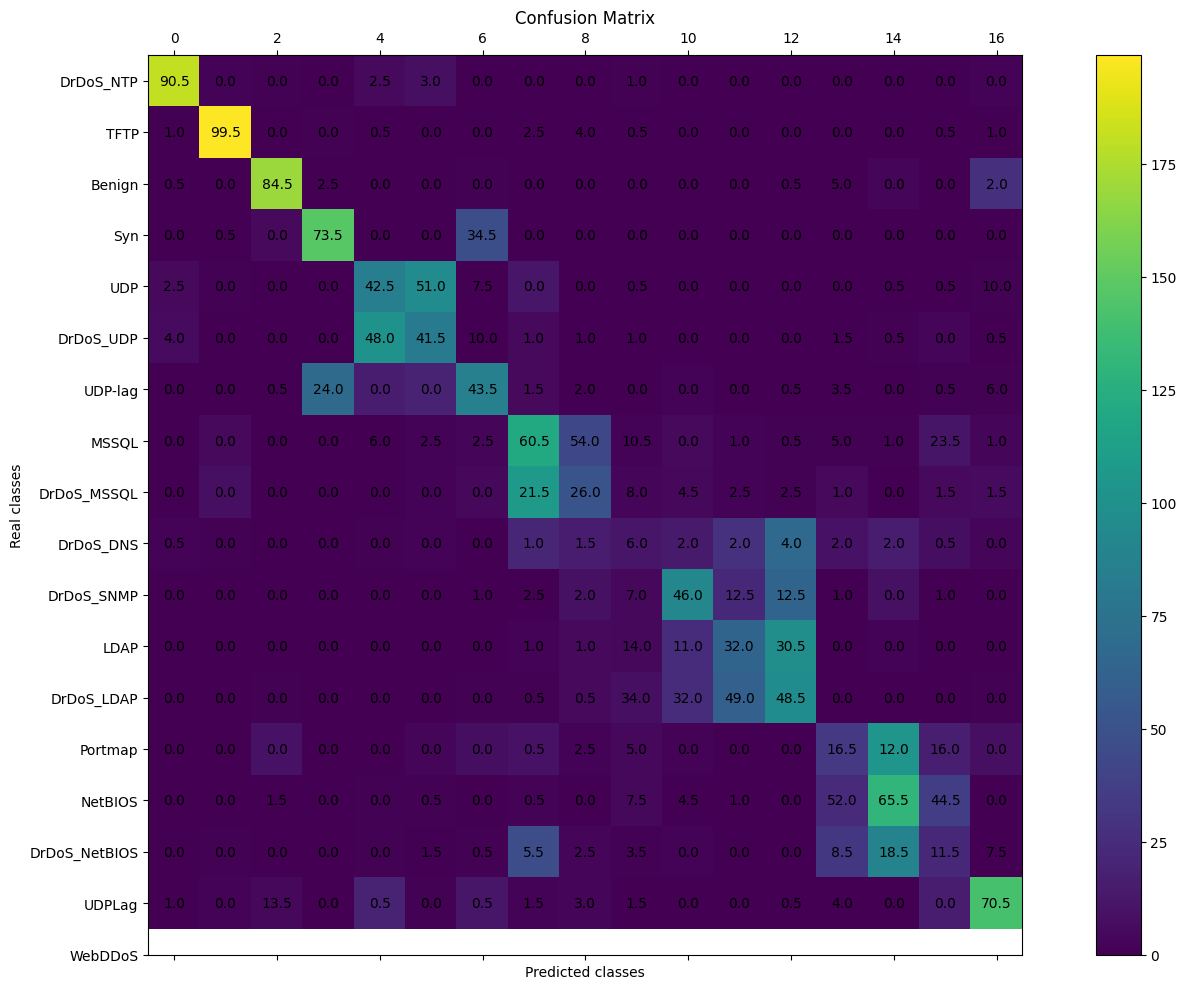

In [42]:
AIRS_model.displayConfusionMatrix()

# MC Pool Visualization

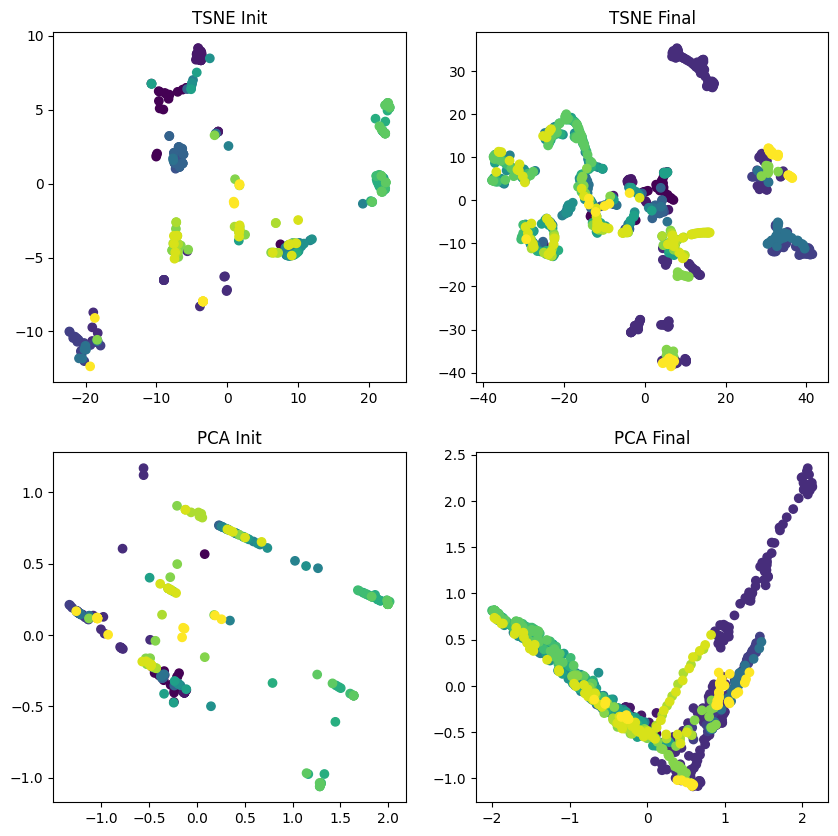

In [43]:
AIRS_model.displayEvolution()

In [44]:
for i in range(len(AIRS_model.MC_iterations)):
    break # nah

    if i % 200 != 0:
        continue

    X_iter = []
    Y_iter = []
    for key in MC_iterations[i].keys():
        for mc_cell in MC_iterations[i][key]:
            X_iter.append(mc_cell.vector)
            Y_iter.append(mc_cell._class)
    X_iter_arr = np.array(X_iter)
    Y_iter_arr = np.array(Y_iter)


    plt.figure(figsize=(10,5))

    plt.subplot(2,1,1)
    plt.title('TSNE')
    X_TSNE = TSNE(n_components=2).fit_transform(X_iter_arr)
    plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=Y_iter_arr)

    plt.subplot(2,1,2)
    plt.title('PCA')
    X_PCA = PCA(n_components=2).fit_transform(X_iter_arr)
    plt.scatter(X_PCA[:,0], X_PCA[:,1], c=Y_iter_arr)

    plt.savefig('MC_evol_{}.png'.format(i))
    plt.close()